<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Atividade_S%C3%A9ries_Temporais2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício

A atividade é **prever para as próximas 6h o valor da concentração de PM2.5**.
Utilize os conceitos aprendidos até aqui, **testando diferentes modelos de IA** e **diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.**  
1.   Escolha uma estação de monitoramento de uma das cidades com que irá trabalhar; 
2.   Faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam;
3.   Explore as técnicas **MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM**, utilizando a camada **TimeDistributed**;
4.   Escolha, com base na avaliação do **loss** e das métricas **MAE, MSE, NMSE, r, R2 e Fac2** qual foi o melhor modelo (e apresente justificando a resposta);
5.   Use o ano de 2015 somente para fins de teste.

### Observação: 
*   *Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor (linhas comentadas);*
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*

### Opcionais:

*   Pode-se utilizar as informações meteorológicas para melhorar a qualidade do modelo final;
*   Interessante, mas não obrigatório, a utilização de wavelets para feature augmentation.


### Links:

* [Código para o colab (referência)](https://colab.research.google.com/drive/1b5177FoO4JsyOKN8dmbmTjvPi32b95of?usp=sharing) 

* [Link da base de dados da atividade](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

* [Link para download da base de dados da atividade](https://drive.google.com/file/d/19FsUZXhakjteNoC3nsqUe2aTq3s7GoQI/view?usp=drive_web&authuser=1)


![title](img/lstm_gru.png)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, MaxPooling3D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Para garantir que nossos resultados sejam reprodutíveis, vamos fixar a semente de aleatorização (random seed) 

In [ ]:
# fixa random seed para garantir reprodutibilidade
np.random.seed(0)

# Carregando os dados

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [176]:
# Carrega o dataset
# df = pd.read_csv('/content/drive/MyDrive/Disciplinas/2021.2/Tópicos_Intel_Comp/Séries_Temporais/FiveCitiesPM/Shanghai.csv', engine='python', skipfooter=3)
df = pd.read_csv('/content/drive/MyDrive/Datasets/FiveCitiesPM/Shanghai.csv', engine='python', skipfooter=3)
df = df.iloc[17443:, :]
df.interpolate(inplace=True)
df_posts = df[['PM_US Post']] 
data = df_posts.values
data = data.astype('float32')
# data = df_posts.values
# data = df_posts.astype('float32')
print('Quantidade de dados no arquivo:', len(data))

Quantidade de dados no arquivo: 35138


In [177]:
# Separando dados de teste e treino
# Ano de 2015 será utilizado para o treino
train = df[df.year != 2015]
test = df[df.year == 2015]

print(len(train))
print(len(test))

# Selecionando coluna de série PM_US Post
train = train[['PM_US Post']]
test = test[['PM_US Post']]

26381
8757


In [178]:
# Primeira posição válida
print (train.loc[train["PM_US Post"].first_valid_index()])

PM_US Post    41.0
Name: 17443, dtype: float64


In [179]:
# Removendo valores NaN da série
# train = train.iloc[17443:, :]

# Criando numpy array
train = train.values
test = test.values

data = df_posts.values

data = data.astype('float32')
train = train.astype('float32')
test = test.astype('float32')

## Visualizando os dados

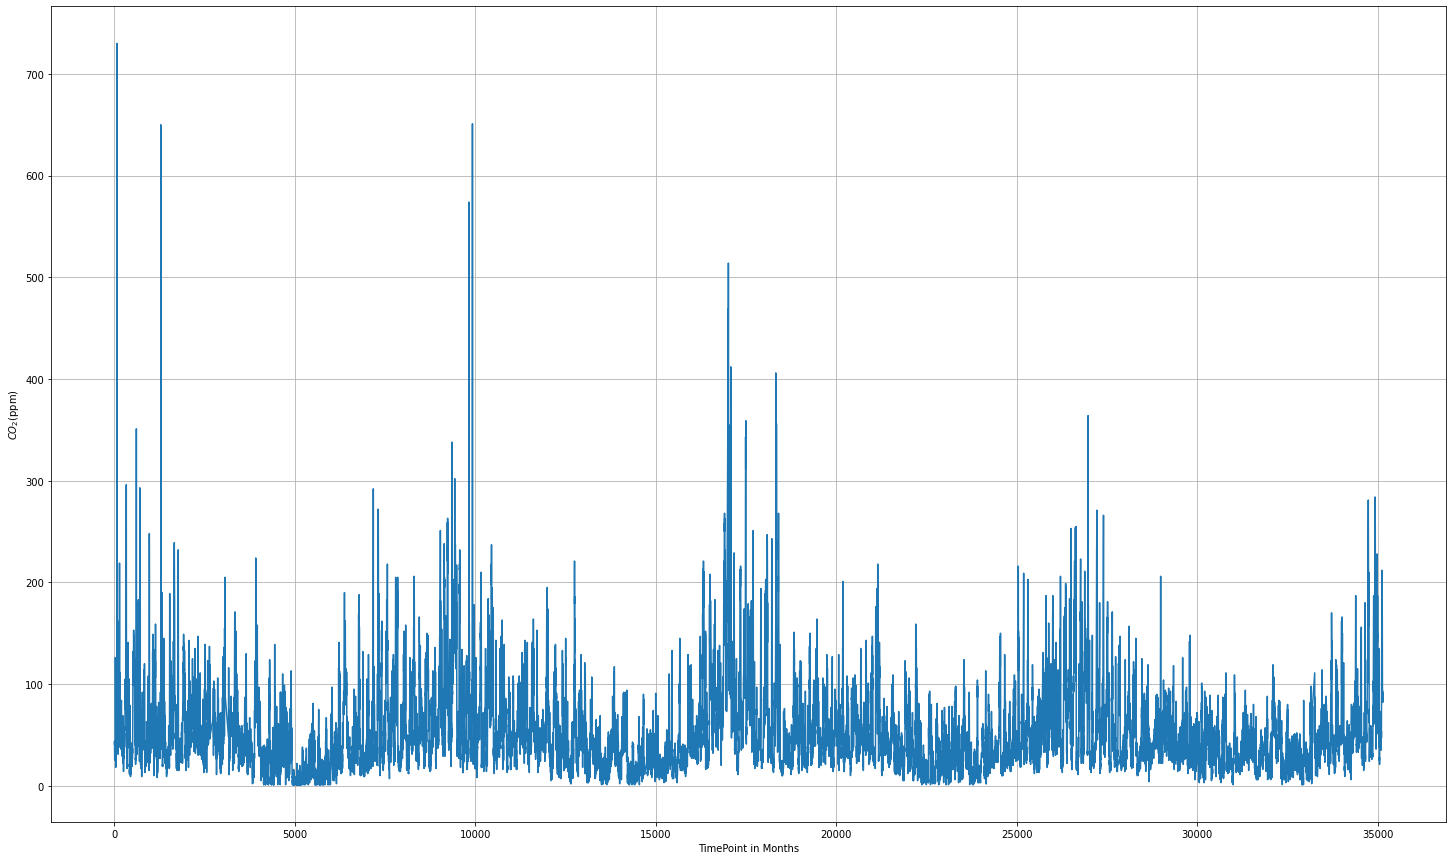

In [180]:
plt.figure(figsize=[25, 15])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);

Em séries temporais, a sequência dos dados é importante. Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste. 


# Tratamento de Dados

In [181]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_fit = scaler.fit_transform(data)
norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

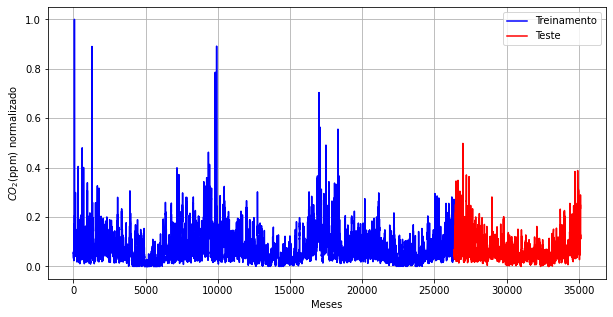

In [182]:
plt.figure(figsize=[10,5])
plt.xlabel('Meses')
plt.ylabel('$CO_2$(ppm) normalizado')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Treinamento','Teste'])

In [156]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

In [157]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 1 # olha somente para a amostra anterior para prever a próxima amostra


A RNN simples espera que os dados de entrada (X) sejam fornecidos na forma de: [sample, time steps, features].

Atualmente, os dados estão no formato: [samples, features], e estamos modelando o problema como um timestep para cada amostra. Usando numpy.reshape () da seguinte forma fazemos a devida transformação:

In [183]:
# # reshape a entrada para [samples, time steps, features]
def reshape_train_test(look_back, split_size):
    trainX_whole, trainY_whole = split_X_y(norm_train, look_back)
    testX, testY = split_X_y(norm_test, look_back)
    trainX_whole = np.reshape(trainX_whole, (trainX_whole.shape[0], look_back, data.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], look_back, data.shape[1]))

    # cria o dataset de validação
    trainX, valX, trainY, valY = train_test_split(trainX_whole, trainY_whole, test_size=split_size)
    return trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY

In [184]:
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

print('Shape de x_train', trainX.shape)
print('Shape de x_val', valX.shape)
print('Shape de x_test', testX.shape)

print('Shape de y_train', trainY.shape)
print('Shape de y_val', valY.shape)
print('Shape de y_test', testY.shape)

trainX

Shape de x_train (7914, 1, 1)
Shape de x_val (18466, 1, 1)
Shape de x_test (8756, 1, 1)
Shape de y_train (7914, 1)
Shape de y_val (18466, 1)
Shape de y_test (8756, 1)


array([[[0.11248285]],

       [[0.08230453]],

       [[0.06447188]],

       ...,

       [[0.09602195]],

       [[0.08641975]],

       [[0.03292181]]], dtype=float32)

Vamos agora projetar e ajustar nossa RNN simples.

A rede tem uma camada visível com 1 entrada, uma camada oculta com 4 blocos recorrentes ou neurônios e uma camada de saída que faz uma previsão de valor único. A função de ativação sigmóide padrão é usada para os blocos recorrentes. A rede é treinada por 20 épocas e um tamanho de lote de 1 é usado.

### Rede RNN simples

In [185]:
# cria e ajusta a RNN simples 
K.clear_session()
model = Sequential()
model.add(SimpleRNN(4, activation='linear', input_shape=(look_back, data.shape[1])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/20
7914/7914 [==============================] - 31s 4ms/step - loss: 4.6012e-04 - val_loss: 4.2293e-04
Epoch 2/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.3089e-04 - val_loss: 4.4272e-04
Epoch 3/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.3598e-04 - val_loss: 4.0502e-04
Epoch 4/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.2727e-04 - val_loss: 4.7778e-04
Epoch 5/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.3357e-04 - val_loss: 4.0718e-04
Epoch 6/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.2276e-04 - val_loss: 4.5385e-04
Epoch 7/20
7914/7914 [==============================] - 33s 4ms/step - loss: 4.2540e-04 - val_loss: 3.9551e-04
Epoch 8/20
7914/7914 [==============================] - 30s 4ms/step - loss: 4.2839e-04 - val_loss: 4.6846e-04
Epoch 9/20
7914/7914 [==============================] - 33s 4ms/step - loss: 4.2327e-04 - val_loss: 9.3408e-04
E

Vamos agora definir uma função para fazer as previsões e plotar. 
Uma vez que o modelo estiver ajustado, podemos estimar o desempenho do modelo nos conjuntos de dados de treinamento e teste.

Observe que devemos inverter (desnormalizar) as previsões antes de calcular a acurácia para garantir que o desempenho seja comparado nas mesmas unidades que os dados originais (ppm por mês).

As previsões foram geradas usando o modelo para o conjunto de dados de treinamento e de teste. Também podemos visualizar os resultados para ter uma indicação de como o modelo funciona.

Ao plotar os dados, devemos deslocar as previsões pelo look_back no tempo para alinhar no eixo x com o conjunto de dados original. Os dados são apresentados com o conjunto de dados original como pontos pretos, as previsões para o conjunto de dados de treinamento em azul e as previsões no conjunto de dados de teste em vermelho.

In [186]:
def plot_history_predictions(history, Xtrain, Ytrain, Xtest, Ytest, scaler, model, title, xlabel, ylabel, lookback):
    # Resumo do historico de loss
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
    plt.show()

    # faz as predições
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xtest)

    # inverte as predições
    if(len(trainPredict.shape)==3):
        trainPredict=trainPredict[:,-1,:]
        testPredict=testPredict[:,-1,:]
    trainPredict = scaler.inverse_transform(trainPredict)
    trainYTrue = scaler.inverse_transform(Ytrain)
    testPredict = scaler.inverse_transform(testPredict)
    testYTrue = scaler.inverse_transform(Ytest)

    # calcula o root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
    print('Treinamento: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
    print('Teste: %.2f RMSE' % (testScore))

    plt.figure(figsize=[10,5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(range(len(data)),data,'k.')
    plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
    plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
    plt.legend(['Original','Treinamento','Teste']);
    

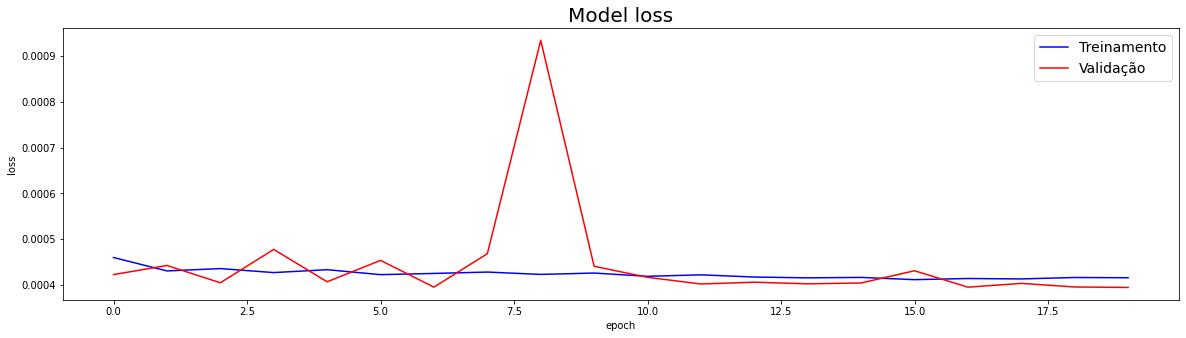

Treinamento: 14.49 RMSE
Teste: 9.95 RMSE


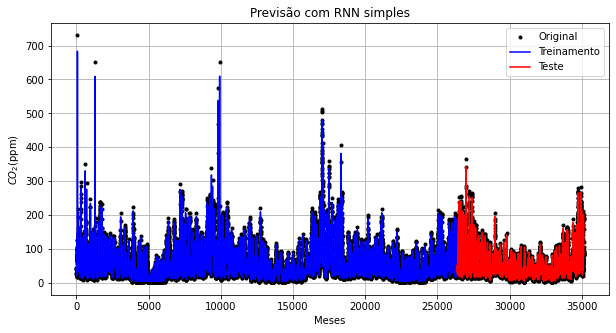

In [187]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, model, 
                         'Previsão com RNN simples', 'Meses', '$CO_2$(ppm)', look_back)

### Rede LSTM

Vamos agora projetar e ajustar nossa rede LSTM.


In [ ]:
# cria e ajusta a rede LSTM 
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back, data.shape[1])))
modelLSTM.add(Dense(1, activation='linear'))

modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/20
39/39 [==============================] - 1s 10ms/step - loss: 0.1234 - val_loss: 0.1020
Epoch 2/20
39/39 [==============================] - 0s 4ms/step - loss: 0.0881 - val_loss: 0.0740
Epoch 3/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0626 - val_loss: 0.0511
Epoch 4/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0371
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0309 - val_loss: 0.0276
Epoch 6/20
39/39 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 7/20
39/39 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 8/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0193
Epoch 9/20
39/39 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0184
Epoch 10/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 11/20
39/39 

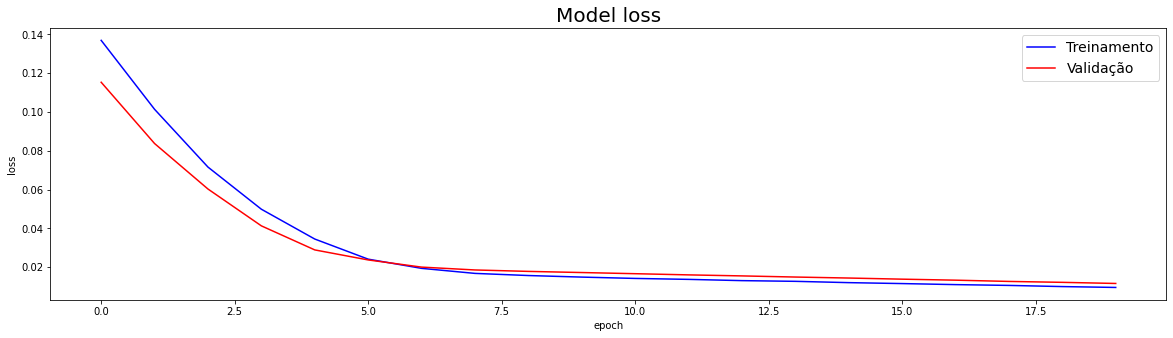

Treinamento: 2.49 RMSE
Teste: 4.74 RMSE


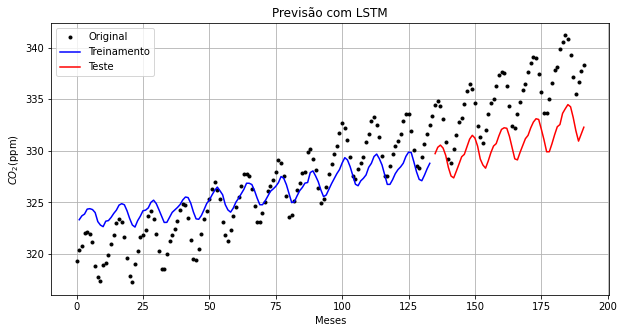

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 3

Melhore os resultados acima tentando o seguinte:
- Aumentar o número de épocas
- Aumentar o valor look_back
- Modificar a arquitetura
- Outros...

Como exemplo, use look_back de 5, aumente o tamanho do dataset de treinamento, aumente o número de épocas e adicione uma camada de dropout


In [ ]:
look_back = 5 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)


In [ ]:
del modelLSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back,data.shape[1])))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')
history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/20
38/38 [==============================] - 0s 13ms/step - loss: 0.1526 - val_loss: 0.1434
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0842 - val_loss: 0.0745
Epoch 3/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0432
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0347 - val_loss: 0.0309
Epoch 5/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0358 - val_loss: 0.0272
Epoch 6/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0257
Epoch 7/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0325 - val_loss: 0.0248
Epoch 8/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0431 - val_loss: 0.0235
Epoch 9/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0213
Epoch 10/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 11/20
38/38 

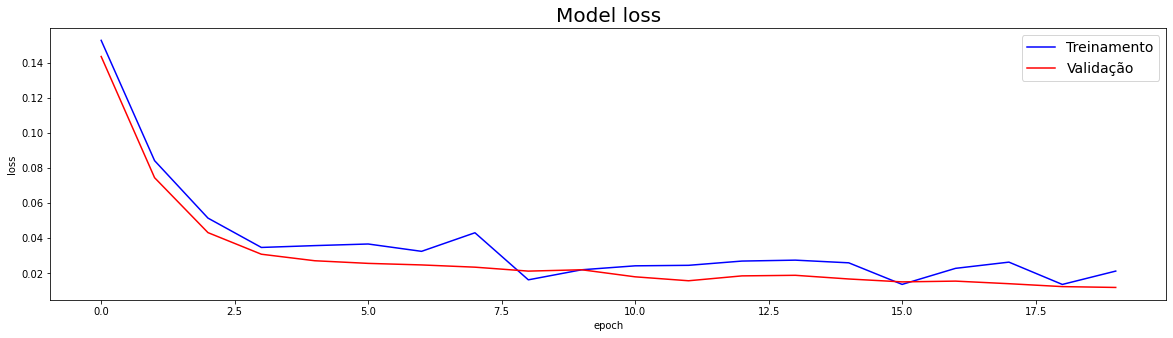

Treinamento: 2.67 RMSE
Teste: 4.73 RMSE


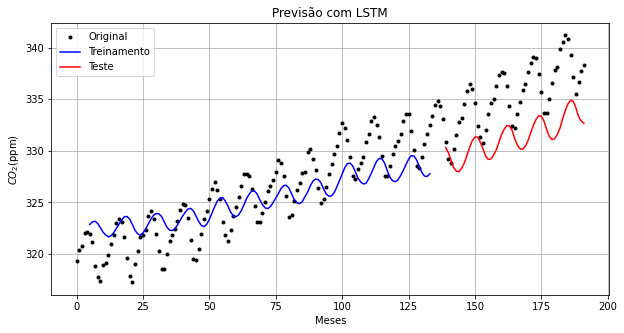

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 4 - Rede GRU

Utilizar outro modelo, a GRU


In [ ]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 5 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

In [ ]:
modelGRU = Sequential()
modelGRU.add(GRU(4, input_shape=(look_back, data.shape[1])))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1, activation='linear'))
modelGRU.compile(loss='mean_squared_error', optimizer='adam')
history = modelGRU.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/20
38/38 [==============================] - 2s 15ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 3/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0071
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0057
Epoch 5/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0058
Epoch 6/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0054
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0071
Epoch 8/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 9/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0056
Epoch 10/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0053
Epoch 11/20
38/38 

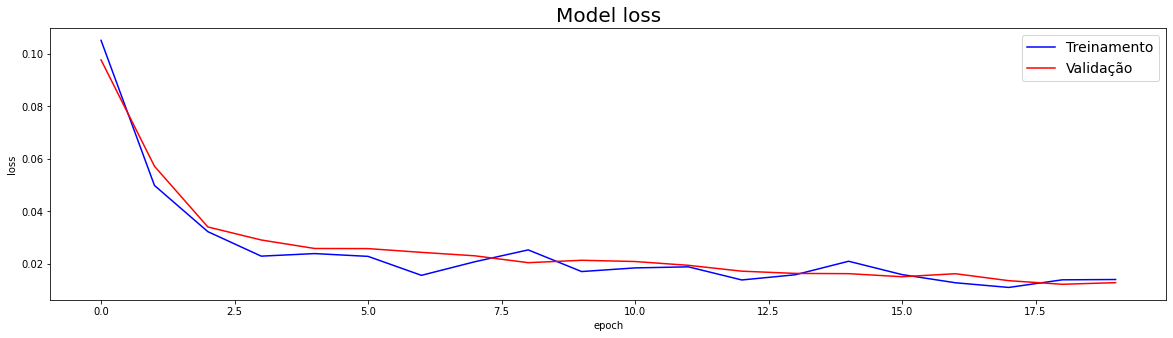

Treinamento: 2.59 RMSE
Teste: 6.05 RMSE


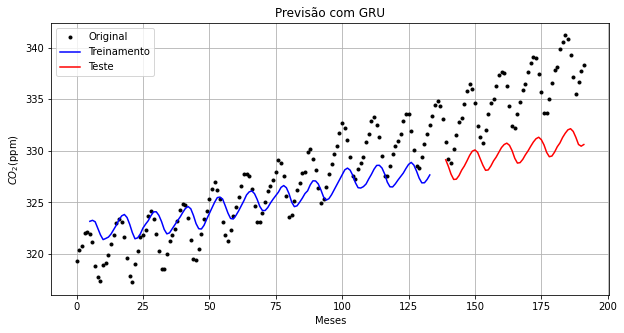

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelGRU, 
                         'Previsão com GRU', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 5 - Rede CNN1D

Utilizar outro modelo, a CNN1D


In [ ]:
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh'))
modelCNN1D.add(MaxPooling1D(pool_size=1))
modelCNN1D.add(Dropout(0.2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(10, activation='tanh'))
modelCNN1D.add(Dense(1, activation='linear'))

modelCNN1D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3210      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1D.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
2/2 [==============================] - 1s 162ms/step - loss: 0.3308 - mse: 0.1456 - val_loss: 0.2004 - val_mse: 0.0525
Epoch 2/20
2/2 [==============================] - 0s 23ms/step - loss: 0.1599 - mse: 0.0370 - val_loss: 0.0799 - val_mse: 0.0098
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0988 - mse: 0.0179 - val_loss: 0.1464 - val_mse: 0.0311
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1431 - mse: 0.0314 - val_loss: 0.1140 - val_mse: 0.0218
Epoch 5/20
2/2 [==============================] - 0s 25ms/step - loss: 0.1297 - mse: 0.0271 - val_loss: 0.0765 - val_mse: 0.0092
Epoch 6/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0828 - mse: 0.0122 - val_loss: 0.0812 - val_mse: 0.0089
Epoch 7/20
2/2 [==============================] - 0s 26ms/step - loss: 0.1048 - mse: 0.0148 - val_loss: 0.0815 - val_mse: 0.0092
Epoch 8/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0931 - mse: 0.0123 - va

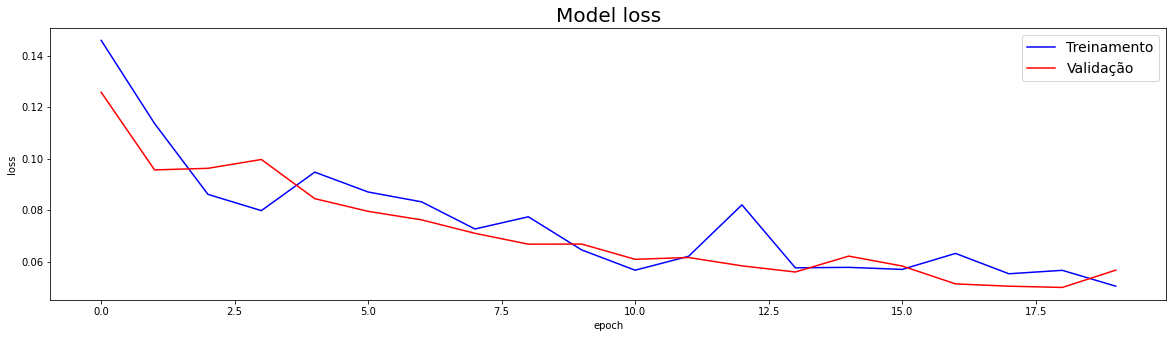

Treinamento: 1.55 RMSE
Teste: 3.27 RMSE


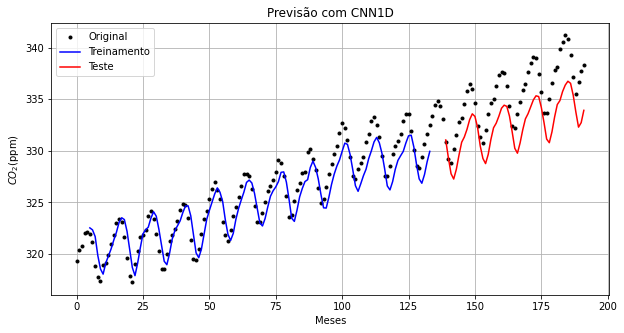

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1D, 
                         'Previsão com CNN1D', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 6


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes.
Nesta primeira parte, vamos criar uma rede que combina operações de convolução, para depois enviar as principais características retornadas para uma camada LSTM. Esta abordagem é chamada muitas vezes de CNN-LSTM, FCN-LSTM ou FC-LSTM.


In [ ]:
modelCNN1DLSTM = Sequential()
modelCNN1DLSTM.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTM.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTM.add(LSTM(16, return_sequences=True))
modelCNN1DLSTM.add(Dropout(0.2))
modelCNN1DLSTM.add(Flatten())
modelCNN1DLSTM.add(Dense(10, activation='tanh'))
modelCNN1DLSTM.add(Dense(1, activation='linear'))

modelCNN1DLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 5, 128)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 16)             9280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                810       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1DLSTM.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1DLSTM.fit(trainX, trainY, epochs=epochs, verbose=verbose, 
                             validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
2/2 [==============================] - 2s 480ms/step - loss: 0.2695 - mse: 0.0974 - val_loss: 0.2228 - val_mse: 0.0642
Epoch 2/20
2/2 [==============================] - 0s 30ms/step - loss: 0.1685 - mse: 0.0421 - val_loss: 0.1238 - val_mse: 0.0216
Epoch 3/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1082 - mse: 0.0173 - val_loss: 0.0838 - val_mse: 0.0105
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0941 - mse: 0.0135 - val_loss: 0.0896 - val_mse: 0.0139
Epoch 5/20
2/2 [==============================] - 0s 27ms/step - loss: 0.1003 - mse: 0.0170 - val_loss: 0.0862 - val_mse: 0.0127
Epoch 6/20
2/2 [==============================] - 0s 26ms/step - loss: 0.1039 - mse: 0.0182 - val_loss: 0.0825 - val_mse: 0.0105
Epoch 7/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1006 - mse: 0.0176 - val_loss: 0.0841 - val_mse: 0.0101
Epoch 8/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0960 - mse: 0.0156 - va

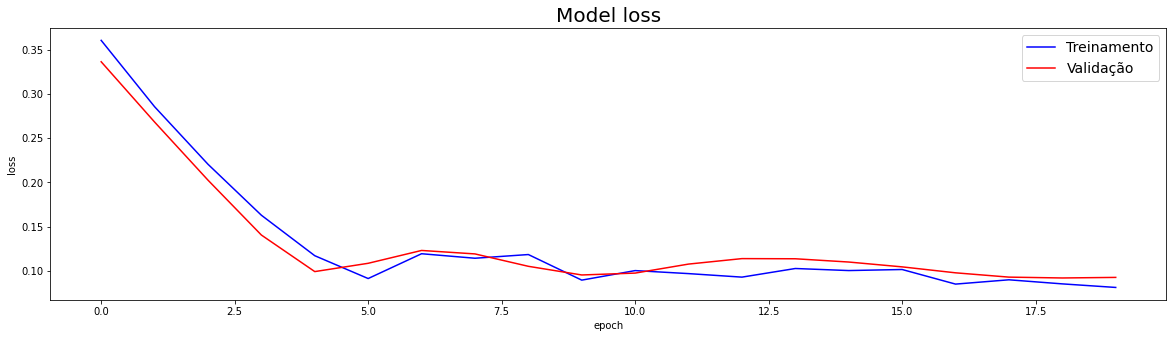

Treinamento: 2.73 RMSE
Teste: 3.11 RMSE


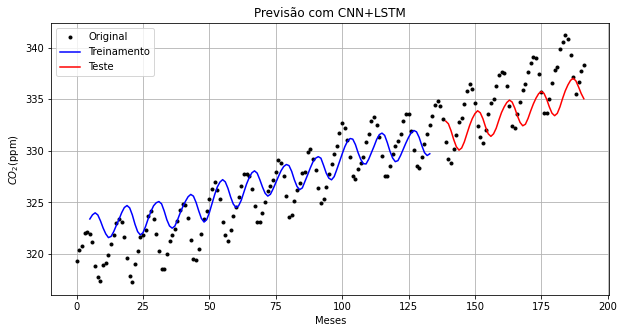

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTM, 
                         'Previsão com CNN+LSTM', 'Meses', '$CO_2$(ppm)', look_back)

### Problema 7


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes: a Conv2DLSTM


In [ ]:
trainX.shape


(38, 5, 1)

In [ ]:
trainX2D = trainX.reshape((trainX.shape[0], trainX.shape[1], 1, trainX.shape[2], 1))
valX2D = valX.reshape((valX.shape[0], valX.shape[1], 1, valX.shape[2], 1))
trainX2D.shape

(38, 5, 1, 1, 1)

In [ ]:
modelConvLSTM2D = Sequential()

modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True,
                           input_shape=(look_back, trainX2D.shape[2], trainX2D.shape[3], trainX2D.shape[4])))
modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True))
modelConvLSTM2D.add(MaxPooling3D(pool_size=(look_back,1,1)))
modelConvLSTM2D.add(Dropout(0.2))
modelConvLSTM2D.add(Flatten())
modelConvLSTM2D.add(Dense(10, activation='tanh'))
modelConvLSTM2D.add(Dense(1, activation='linear'))


In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelConvLSTM2D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelConvLSTM2D.fit(trainX2D, trainY, epochs=epochs, verbose=verbose, validation_data=(valX2D, valY), 
                              batch_size=batch_size)

Epoch 1/20
2/2 [==============================] - 5s 474ms/step - loss: 0.2898 - mse: 0.1131 - val_loss: 0.3027 - val_mse: 0.1150
Epoch 2/20
2/2 [==============================] - 0s 52ms/step - loss: 0.2346 - mse: 0.0783 - val_loss: 0.2367 - val_mse: 0.0730
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 0.1780 - mse: 0.0485 - val_loss: 0.1611 - val_mse: 0.0361
Epoch 4/20
2/2 [==============================] - 0s 49ms/step - loss: 0.1291 - mse: 0.0255 - val_loss: 0.0985 - val_mse: 0.0145
Epoch 5/20
2/2 [==============================] - 0s 47ms/step - loss: 0.1120 - mse: 0.0179 - val_loss: 0.1088 - val_mse: 0.0197
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 0.1372 - mse: 0.0269 - val_loss: 0.1040 - val_mse: 0.0180
Epoch 7/20
2/2 [==============================] - 0s 56ms/step - loss: 0.1274 - mse: 0.0253 - val_loss: 0.0929 - val_mse: 0.0134
Epoch 8/20
2/2 [==============================] - 0s 54ms/step - loss: 0.1127 - mse: 0.0176 - va

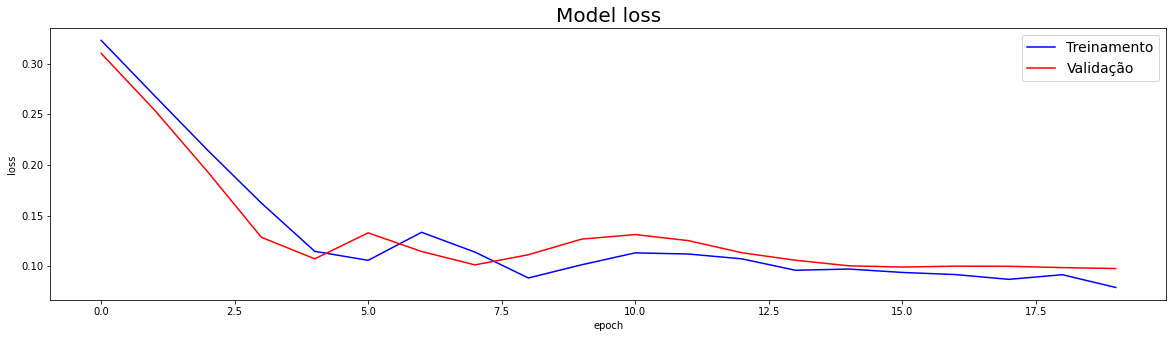

Treinamento: 2.78 RMSE
Teste: 4.05 RMSE


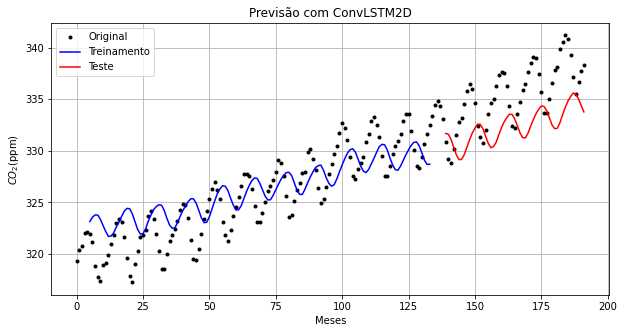

In [ ]:
trainX2D_whole = trainX_whole.reshape((trainX_whole.shape[0], trainX_whole.shape[1], 1, trainX_whole.shape[2], 1))
testX2D = testX.reshape((testX.shape[0], testX.shape[1], 1, testX.shape[2], 1))


plot_history_predictions(history, trainX2D_whole, trainY_whole, testX2D, testY, scaler, modelConvLSTM2D, 
                         'Previsão com ConvLSTM2D', 'Meses', '$CO_2$(ppm)', look_back)

### Problema 8


Vamos aprender a utilizar a camada TimeDistributed <p>
Para tal, vamos configurar uma rede sem, e outra com, a camada TimeDistributed, e vamos comparar o desempenho de ambas.
    
Fonte: https://keras.io/api/layers/recurrent_layers/time_distributed/


In [ ]:
#Rede FCN+LSTM sem TimeDistributed
modelCNN1DLSTMSemTD = Sequential()
modelCNN1DLSTMSemTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMSemTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMSemTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMSemTD.add(Dense(10, activation='tanh'))
modelCNN1DLSTMSemTD.add(Dense(1, activation='linear'))

#Rede FCN+LSTM com TimeDistributed
modelCNN1DLSTMTD = Sequential()
modelCNN1DLSTMTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(10, activation='tanh')))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(1, activation='linear')))


In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

#treinando a rede sem TimeDistributed
modelCNN1DLSTMSemTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historySemTD = modelCNN1DLSTMSemTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
2/2 [==============================] - 2s 478ms/step - loss: 0.3240 - mse: 0.1382 - val_loss: 0.3536 - val_mse: 0.1550
Epoch 2/20
2/2 [==============================] - 0s 28ms/step - loss: 0.2760 - mse: 0.1065 - val_loss: 0.3006 - val_mse: 0.1152
Epoch 3/20
2/2 [==============================] - 0s 28ms/step - loss: 0.2301 - mse: 0.0786 - val_loss: 0.2487 - val_mse: 0.0819
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1892 - mse: 0.0569 - val_loss: 0.1982 - val_mse: 0.0555
Epoch 5/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1552 - mse: 0.0395 - val_loss: 0.1549 - val_mse: 0.0369
Epoch 6/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1303 - mse: 0.0285 - val_loss: 0.1309 - val_mse: 0.0274
Epoch 7/20
2/2 [==============================] - 0s 30ms/step - loss: 0.1249 - mse: 0.0253 - val_loss: 0.1309 - val_mse: 0.0265
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1317 - mse: 0.0272 - va

In [ ]:
# treinando a rede com TimeDistributed
modelCNN1DLSTMTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyTD = modelCNN1DLSTMTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
2/2 [==============================] - 2s 465ms/step - loss: 0.3035 - mse: 0.1222 - val_loss: 0.3202 - val_mse: 0.1288
Epoch 2/20
2/2 [==============================] - 0s 27ms/step - loss: 0.2485 - mse: 0.0873 - val_loss: 0.2599 - val_mse: 0.0886
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 0.1971 - mse: 0.0611 - val_loss: 0.2025 - val_mse: 0.0576
Epoch 4/20
2/2 [==============================] - 0s 27ms/step - loss: 0.1575 - mse: 0.0407 - val_loss: 0.1540 - val_mse: 0.0365
Epoch 5/20
2/2 [==============================] - 0s 26ms/step - loss: 0.1330 - mse: 0.0289 - val_loss: 0.1303 - val_mse: 0.0271
Epoch 6/20
2/2 [==============================] - 0s 27ms/step - loss: 0.1254 - mse: 0.0253 - val_loss: 0.1282 - val_mse: 0.0257
Epoch 7/20
2/2 [==============================] - 0s 31ms/step - loss: 0.1282 - mse: 0.0260 - val_loss: 0.1299 - val_mse: 0.0258
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1314 - mse: 0.0269 - va

In [ ]:
#vamos ver o shape retornado do predict da rede com e sem TimeDistributed
tsTD=modelCNN1DLSTMSemTD.predict(testX);
print(tsTD.shape, len(tsTD.shape))

tTD=modelCNN1DLSTMTD.predict(testX);
print(tTD.shape, len(tTD.shape))




(53, 5, 1) 3
(53, 5, 1) 3


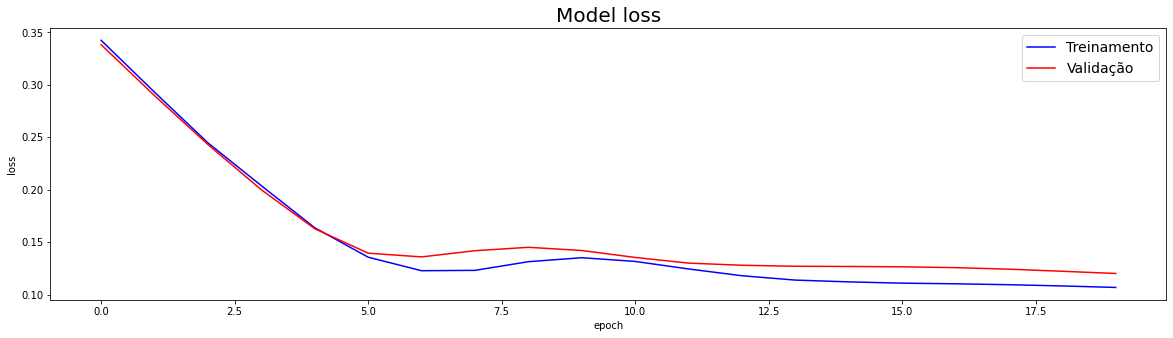

Treinamento: 2.61 RMSE
Teste: 3.28 RMSE


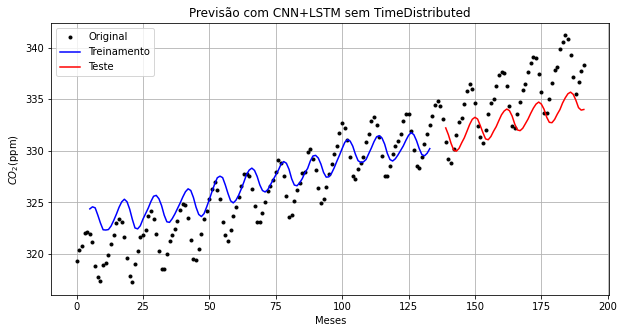

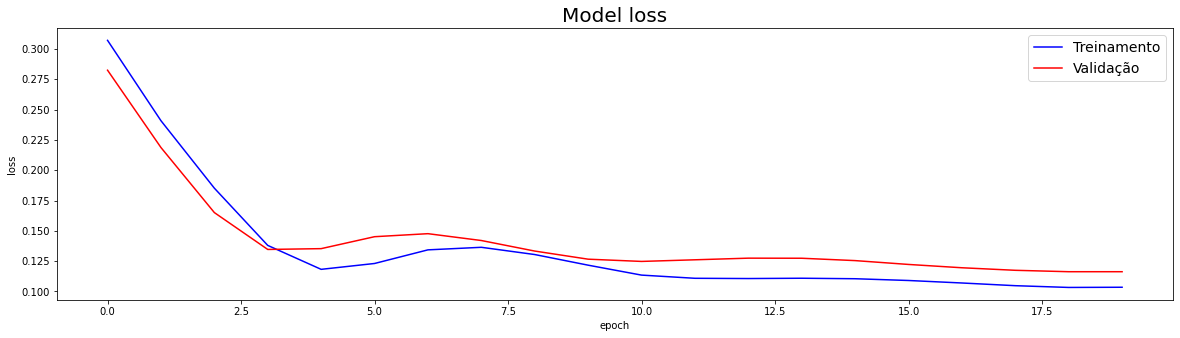

Treinamento: 2.84 RMSE
Teste: 1.97 RMSE


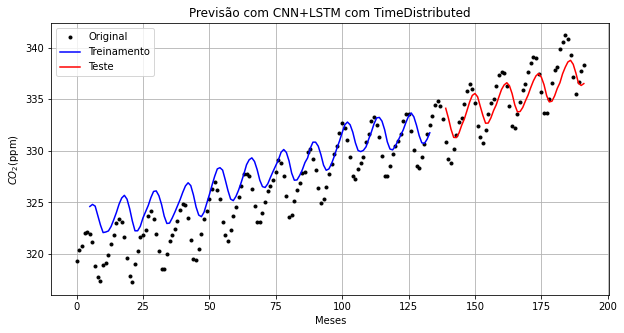

In [ ]:
plot_history_predictions(historySemTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMSemTD, 
                         'Previsão com CNN+LSTM sem TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)

plot_history_predictions(historyTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMTD, 
                         'Previsão com CNN+LSTM com TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)



### Exercício

Neste exercício, vamos construir um preditor de séries temporais e treiná-lo para prever uma única série temporal. Usaremos um conjunto de dados fornecido pelo [UCI Machine Learning Repository] (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) que possui dados de monitoramento da qualidade do ar nas cidades chinesas / distritos. Os dados se referem a concentração de material particulado de diametro menor que 2,5 micrometros (PM2.5), que são as partículas finas inaláveis pelo ser humano e perigosas a saúde. O período de monitoramento é de 01/01/2010 a 31/12/2015. Dados faltantes são denotados como NaN.

Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220 to 10236, [Web Link].


#### Configurando os dados

Começaremos trabalhando com dados de Pequim e filtraremos o conjunto de dados para registros a partir de 2015.




In [ ]:
file = "FiveCitiesPM.zip"
  
# open the zip file in read mode
with ZipFile(file, 'r') as zip: 
    # extract all files to another directory
    zip.extractall('./')

In [ ]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [ ]:
# interpolando os dados
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

### A atividade é prever para as próximas 6h o valor da concentração de PM2.5. 

Utilize os conceitos aprendidos até aqui, testando diferentes modelos de IA e diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.

1. Inicialmente, escolha uma estação de monitoramento de uma das cidades com que irá trabalhar, e faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam.
2. Explore as técnicas MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM, utilizando a camada TimeDistributed;
3. Escolha, com base na avaliação do loss e das métricas MAE, MSE, NMSE, r, R2 e Fac2 qual foi o melhor modelo;
4. Use o ano de 2015 para fins de teste;
5. Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor;


Importante: o trabalho deve ser feito em grupo. <br>

Importante2: Conseguir utilizar as informações meteorológicas para melhorar a qualidade do modelo final;  <br>
Importante3: Utilização de wavelets para feature augmentation. <br>

